Parts of Duffision model building:
1. Forward process
- Noise schedule (betas, alphas)
2. Denoising process
- UNET ( task specific blocks: time embeddings, residual connections, attention blocks)
- Additional image guidance
- LDM implementation (?)
3. Sampling
- Same UNET but using something on top to speed it up

#### Data and imports

In [1]:
! pip install diffusers
! pip install torchvision
! pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 82.7 MB/s eta 0:00:00


In [3]:
from einops import rearrange
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [4]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:02<00:00, 4555800.48it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 134579.96it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1277727.67it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 9953254.32it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([3, 1, 7, 2, 8, 8, 2, 0])


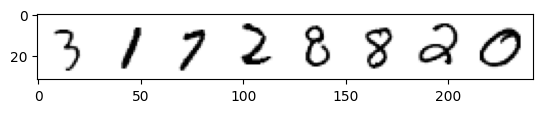

In [5]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

#### Forward process

In [8]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount

In [9]:
def linear_schedule(T, start = 0.0001, end = 0.02):
    return torch.linspace(start, end, T)

def cosine_schedule(T, s = 0.008):
        a_t_bar = torch.cos((torch.linspace(0,T, T+1) / T + s) / (1 + s) * 0.5 * torch.pi) ** 2
        a_t = a_t_bar[1:] / a_t_bar[:-1]
        return 1 - a_t


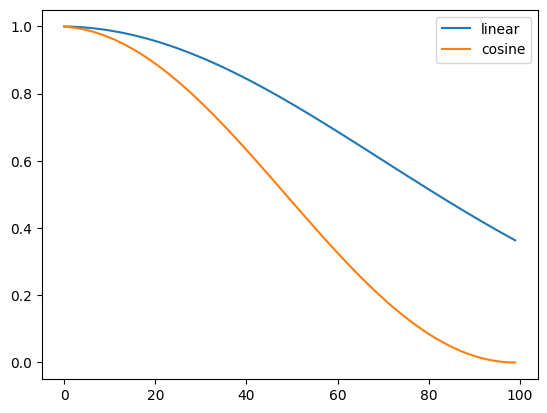

In [10]:
T = 100
a_bar_cosine = torch.cumprod(1 - cosine_schedule(T), dim = 0)
a_bar_linear = torch.cumprod(1 - linear_schedule(T), dim = 0)
plt.plot(a_bar_linear)
plt.plot(a_bar_cosine)
plt.legend(["linear", "cosine"])
plt.show()

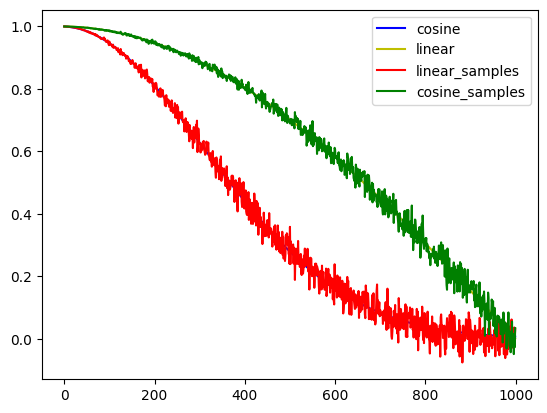

In [11]:
T = 1000

a_bar_linear = torch.cumprod(1- linear_schedule(T), dim= 0)
linear_samples = torch.stack([torch.normal(a_bar_linear**0.5, (1- a_bar_linear)) for i in range(1000)], dim = 0).mean(dim=0)

a_bar_cosine = torch.cumprod(1- cosine_schedule(T), dim= 0)
cosine_samples = torch.stack([torch.normal(a_bar_cosine**0.5, (1- a_bar_cosine)) for i in range(1000)], dim = 0).mean(dim=0)

plt.plot(a_bar_linear**0.5, color = 'b')
plt.plot(a_bar_cosine**0.5, color = 'y')
plt.plot(linear_samples, color = 'r')
plt.plot(cosine_samples, color = 'g')
plt.legend(['cosine','linear', 'linear_samples', 'cosine_samples'])
plt.show()

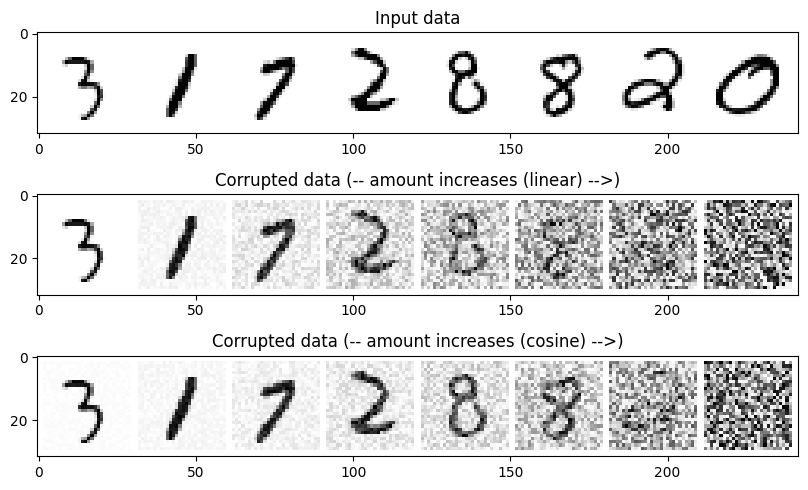

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(18, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding linear noise
amount_linear = linear_schedule(x.shape[0], end = 1) # Left to right -> more corruption
noised_x_linear = corrupt(x, amount_linear)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases (linear) -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x_linear)[0], cmap='Greys');

# Adding linear noise
amount_cosine = cosine_schedule(x.shape[0]) # Left to right -> more corruption
noised_x_cosine = corrupt(x, amount_cosine)

# Plotting the noised version
axs[2].set_title('Corrupted data (-- amount increases (cosine) -->)')
axs[2].imshow(torchvision.utils.make_grid(noised_x_cosine)[0], cmap='Greys');
plt.tight_layout()

#### U-Net

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.05):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        return self.conv(x)

In [14]:
class AttentionBlock(nn.Module):
    def __init__(self, C: int, num_heads:int = 4 , dropout_prob: float = 0.05):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:] # extracting height and width
        x = rearrange(x, 'b c h w -> b (h w) c') # falttening image L = h*w
        x = self.proj1(x) # linear layer two increase amount of channels by a factor of 3
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads) # divide channels into 3 parts (Q,K,V) and distribute to K attention heads
        q,k,v = x[0], x[1], x[2] # Reassignment
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob) # dot product attention
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w) # reshape to initial batch, height, width, channels
        x = self.proj2(x) # Linear layer on top
        return rearrange(x, 'b h w C -> b C h w') # rearrange to PyTorch familiar shape

In [33]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x, t):
        encoding = torch.zeros(self.dim, device=x.device)
        sin_part = torch.sin(t / 10000 ** (torch.arange(0, self.dim, 2, device=x.device) / self.dim))
        cos_part = torch.cos(t / 10000 ** (torch.arange(1, self.dim, 2, device=x.device) / self.dim))
        encoding[::2] = sin_part
        encoding[1::2] = cos_part
        # add batch size and channel dims
        encoding = encoding.repeat(x.shape[0], 1)
        return encoding[:,:, None, None]

In [99]:
class DiffUNet(nn.Module):
    def __init__(self, in_channels=1,
                 out_channels=1,
                 num_heads = 8,

                 ):
        super().__init__()
        self.conv1 = ConvBlock(1, 32)
        self.conv2 = ConvBlock(32, 64)
        self.conv3 = ConvBlock(64, 128)

        self.attn1 = AttentionBlock(64, num_heads=num_heads)

        self.conv4 = ConvBlock(256, 128)
        self.conv5 = ConvBlock(128, 64)
        self.conv6 = ConvBlock(64, 32)

        self.attn2 = AttentionBlock(64, num_heads=num_heads)

        self.lastconv = nn.Conv2d(32, 1, kernel_size=3, padding=1)

        self.middleconv = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upscale1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upscale2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)

        self.timeemb = TimeEmbedding(32)

    def forward(self, x, t):
        x1_down = self.conv1(x)
        x1_down += self.timeemb(x, t)
        x2_down = self.conv2(self.maxpool(x1_down))
        x2_down = self.attn1(x2_down)
        x3_down = self.conv3(self.maxpool(x2_down))

        h = self.middleconv(x3_down)

        x1_up = self.conv4(torch.cat((h, x3_down), dim=1))
        x2_up = self.conv5(torch.cat((self.upscale1(x1_up), x2_down), dim=1))
        x2_up = self.attn2(x2_up)
        x3_up = self.conv6(torch.cat((self.upscale2(x2_up), x1_down), dim=1))
        output = self.lastconv(x3_up)

        return output




In [100]:
net = DiffUNet()
x = torch.rand(8, 1, 28, 28)
net(x, 3).shape

torch.Size([8, 1, 28, 28])

In [101]:
sum([p.numel() for p in net.parameters()])

1091489

### Training

In [102]:
#progress bar import
from tqdm.notebook import tqdm

In [137]:
T = 300
noise_schedule = cosine_schedule(T)
noise_schedule = torch.clip(noise_schedule, 0.0001, 0.999)


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average loss for this epoch: 0.098399


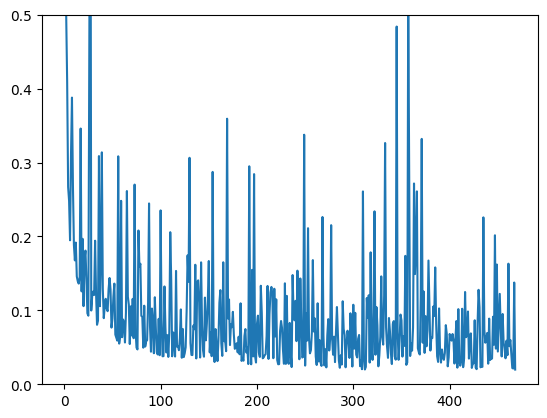

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average loss for this epoch: 0.060229


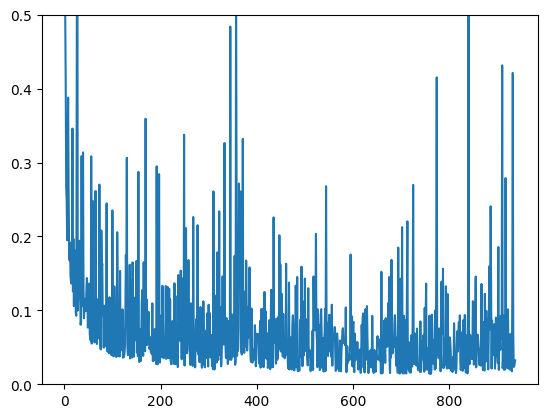

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average loss for this epoch: 0.056515


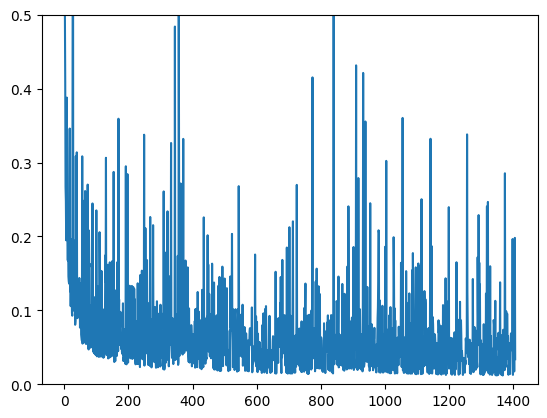

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 3. Average loss for this epoch: 0.049566


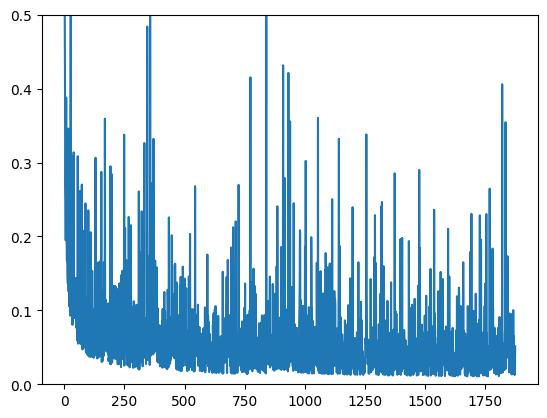

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 4. Average loss for this epoch: 0.050791


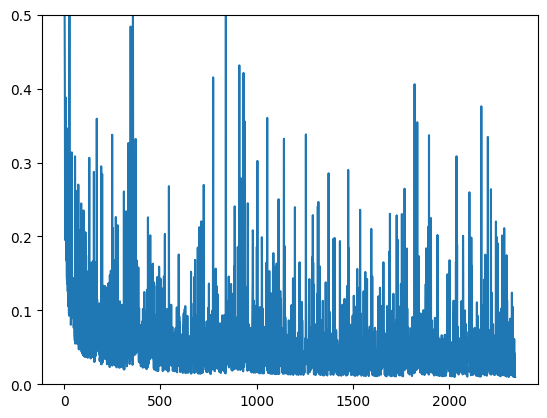

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 5. Average loss for this epoch: 0.049367


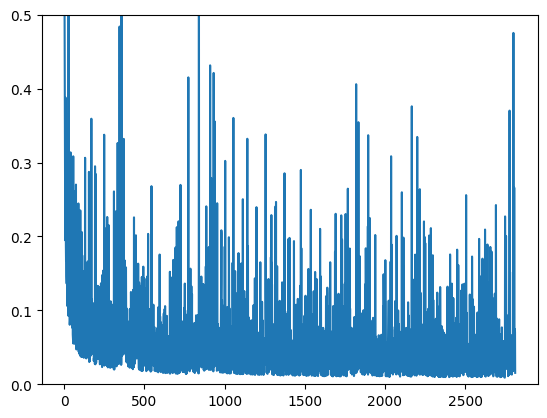

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 6. Average loss for this epoch: 0.045869


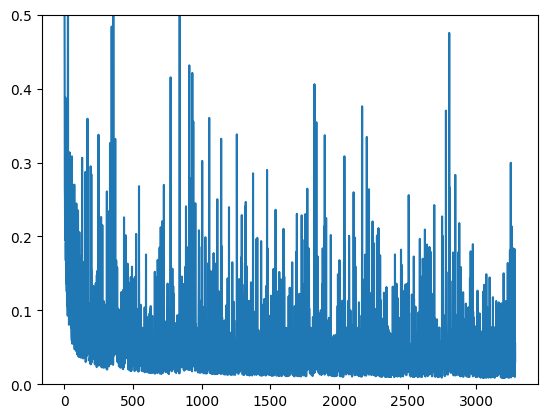

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 7. Average loss for this epoch: 0.043292


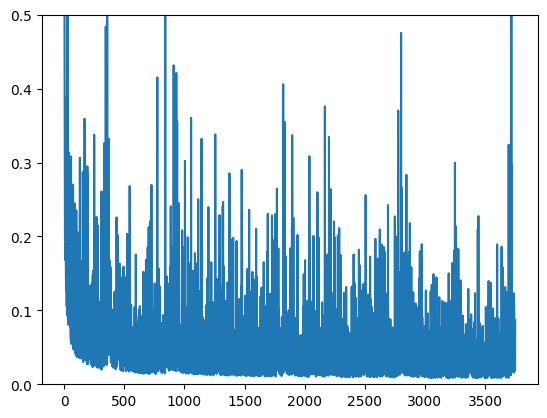

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 8. Average loss for this epoch: 0.046329


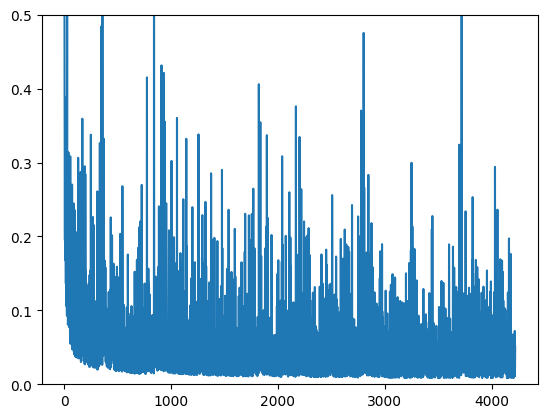

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 9. Average loss for this epoch: 0.042082


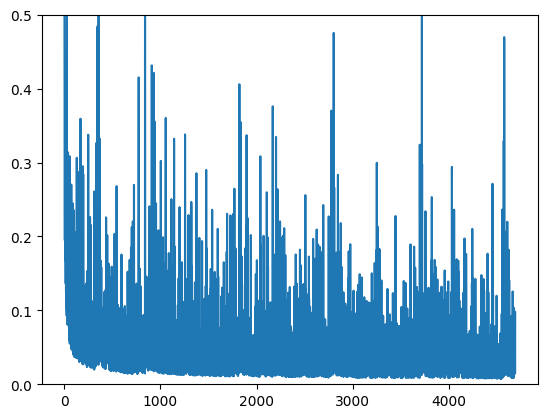

In [138]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Create the network
net = DiffUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

a_bar = torch.cumprod(1- cosine_schedule(T), dim= 0).to(device)

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        t = torch.randint(0,T, (1,)).to(device)
        a_bar_t = a_bar[t]

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU


        eps = torch.randn_like(x, requires_grad=False)

        noisy_x = (torch.sqrt(a_bar_t)*x) + (torch.sqrt(1-a_bar_t)*eps)


        # Get the model prediction
        pred = net(noisy_x, t)

        # Calculate the loss
        loss = loss_fn(pred, eps)

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch+1}. Average loss for this epoch: {avg_loss:05f}')

    # View the loss curve
    plt.plot(losses)
    plt.ylim(0, 0.5)
    plt.show()

In [139]:
torch.save(net, 'entire_model.pth')

### Sampling

In [141]:
a = torch.load('/content/entire_model.pth')

<ipython-input-141-94d8b7f6aa67>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  a = torch.load('/content/entire_model.pth')


In [157]:
shape_x = x.shape
num_samples = 1

samples = torch.randn(num_samples, shape_x[1], shape_x[2], shape_x[3]).to(device)
samples.shape

torch.Size([1, 1, 28, 28])

In [ ]:
for i in samples:
  plt.imshow(i[0].cpu(), cmap='Greys')
  plt.show()

Time step 280


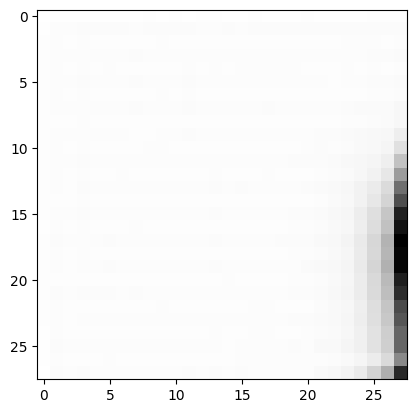

Time step 260


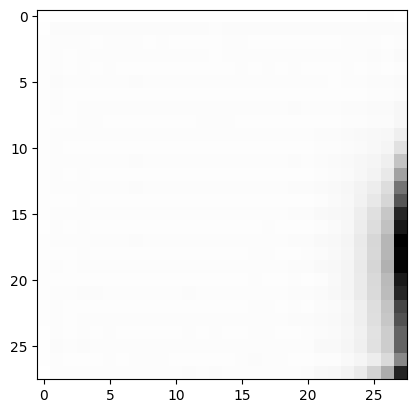

Time step 240


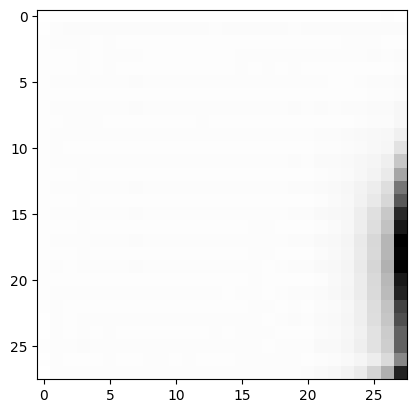

Time step 220


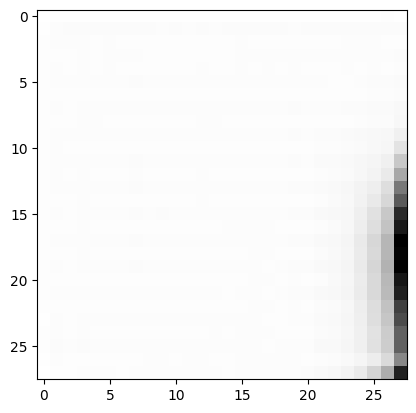

Time step 200


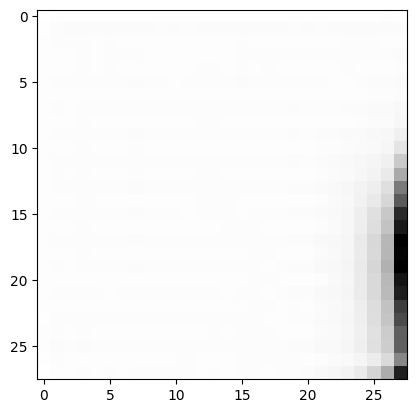

Time step 180


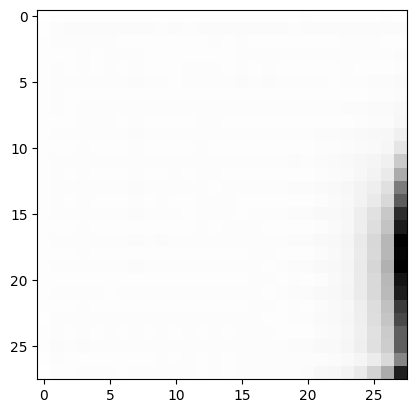

Time step 160


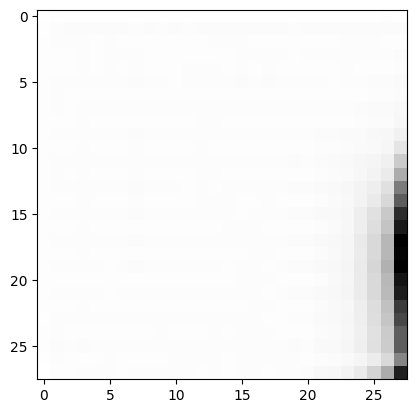

Time step 140


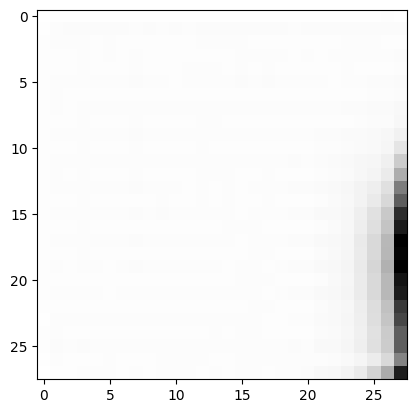

Time step 120


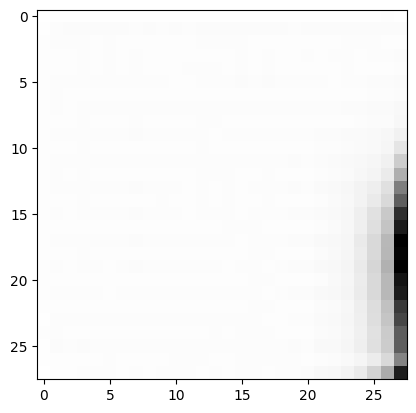

Time step 100


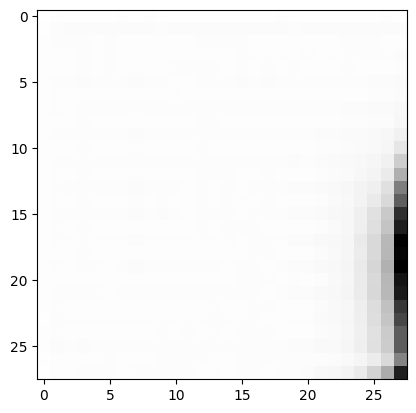

Time step 80


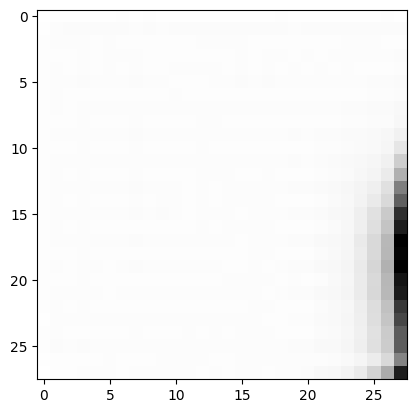

Time step 60


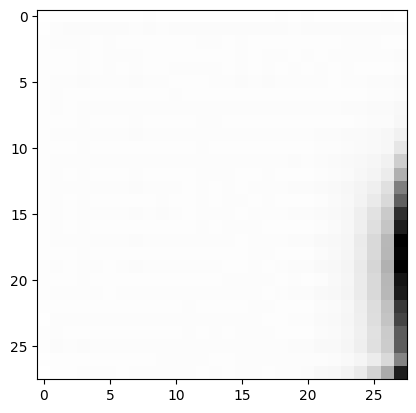

Time step 40


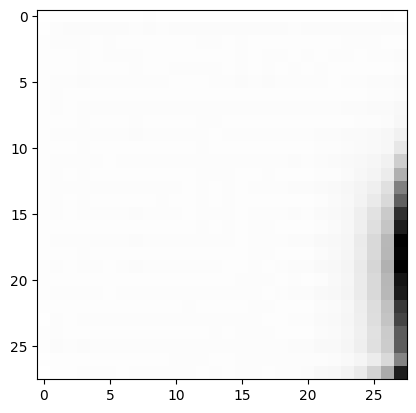

Time step 20


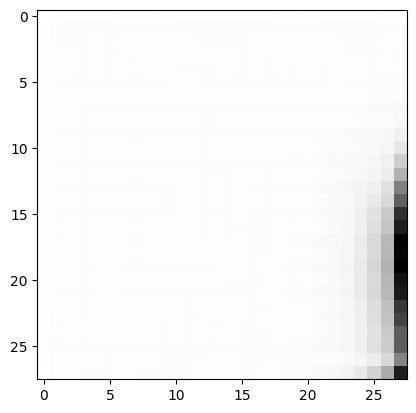

Time step 0


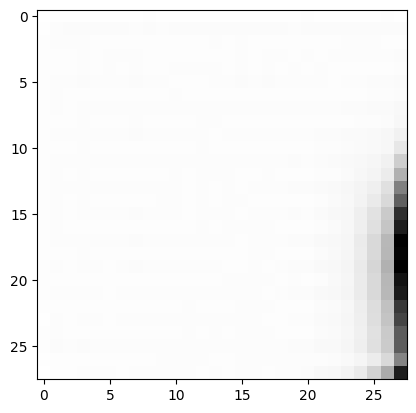

In [160]:
with torch.no_grad():
  a.eval()
  for t in reversed(range(T)):
    timestep = torch.tensor(t).to(device)
    noise_pred = a(samples, timestep)
    beta_t = noise_schedule[t]

    if t % 20 == 0:
      print(f'Time step {t}')
      plt.imshow(samples.cpu().squeeze(0)[0], cmap='Greys')
      plt.show()

    if t > 0:
        # Calculate the standard deviation for sampling
        std_dev = (1 - beta_t) ** 0.5
        samples = (1 / std_dev) * (samples - beta_t * noise_pred) + std_dev * torch.randn_like(samples)
    else:
        samples = samples - beta_t * noise_pred  # No noise added on the last step



In [30]:
eps.device

device(type='cuda', index=0)

Sources of inspiration:

- https://github.com/huggingface/diffusion-models-class
- https://nn.labml.ai/diffusion
- https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/model.py

